In [1]:
import napari
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from dottamine import dotim
from cv2 import GaussianBlur


In [324]:
image = sk.io.imread('domes/domes_n2v/70_denoised.tif')
# image = sk.io.imread('domes/Nice Domes/70.tif')
image = np.transpose(image[0], axes=(1,0,2))

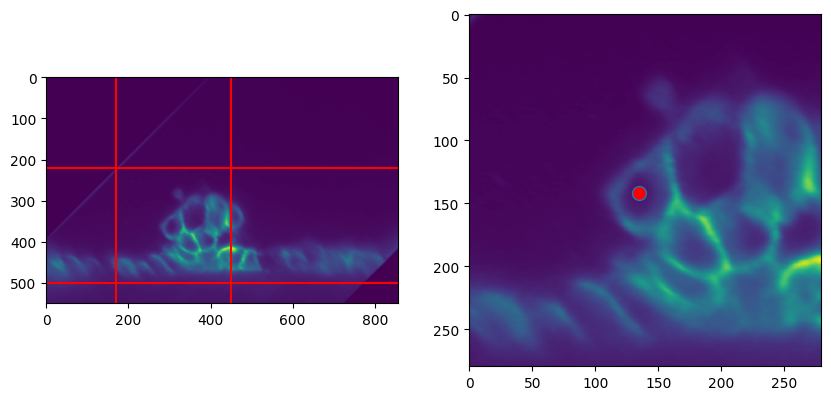

In [232]:
y1 = 300
y2 = 380
x1 = 420
x2 = 500

y1 = 220
y2 = 500
x1 = 170
x2 = 450

z1 = 75
z2 = 140

z = 100
im = image[z][y1:y2, x1:x2]

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')
plt.imshow(image[z])
plt.subplot(122)
plt.imshow(im)
# 135, 142
plt.plot(135,142, marker="o", markersize=10, markerfacecolor="red")

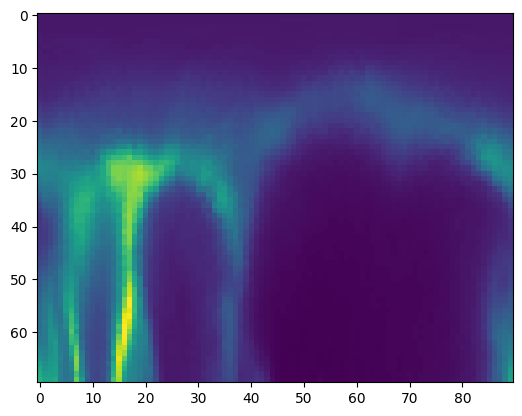

In [233]:
# Get the radial values of the intensity.

m = list(range(90)) # Angle
n = list(range(70)) # Radial points

intensities = np.zeros((len(n), len(m)))

dAngle = 360/(max(m)+1)
center = (135,142) # Y, X

def xAxis(p, a):
    return p*np.cos(dAngle*a*np.pi/180)+center[1]
    
def yAxis(p,a):
    return p*np.sin(dAngle*a*np.pi/180)+center[0]

for a in m:
    for r in n:
        
        intensities[r][a] = im[int(xAxis(r, a))][int(yAxis(r,a))]
        # print(dAngle*a, r, int(xAxis(r, a)), int(yAxis(r,a)))

plt.imshow(intensities)

(70, 90)


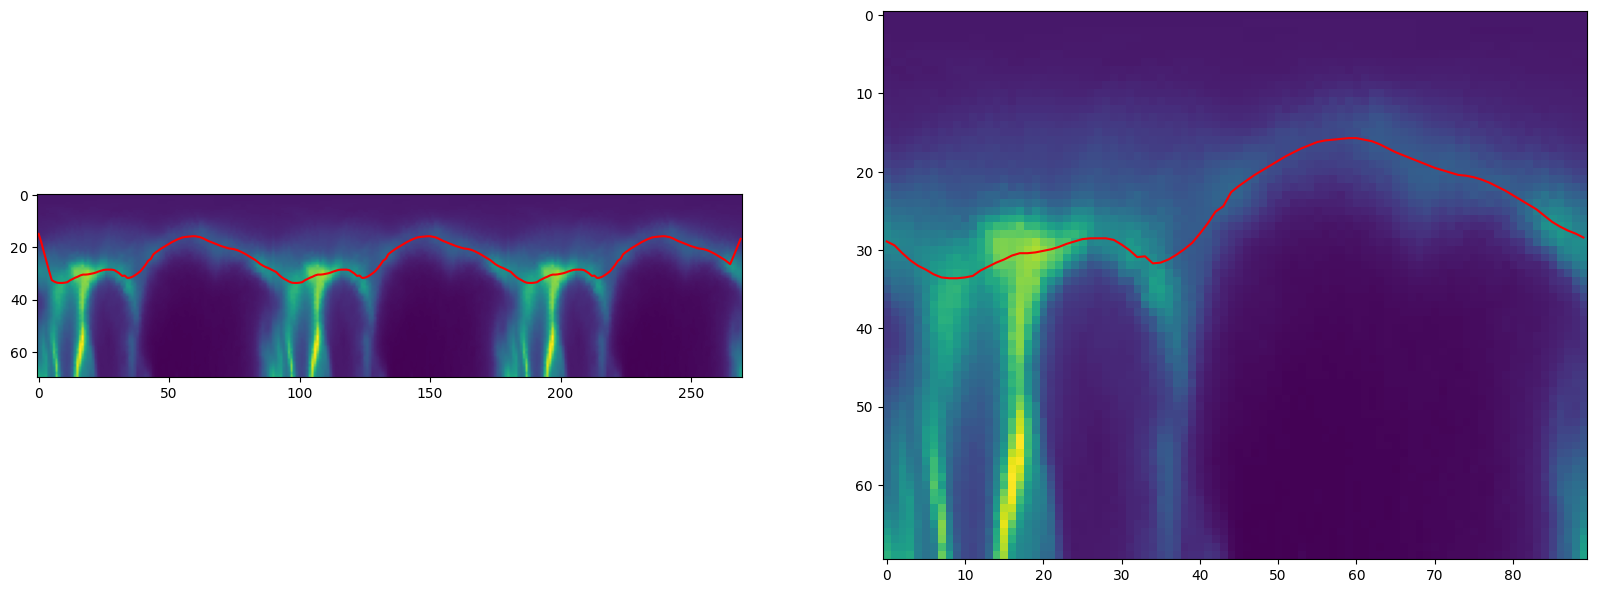

In [287]:
def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

cell_border = []

plt.figure(figsize=(20, 20))

for i in range(intensities.shape[1]):
    x = np.linspace(0, 1, len(intensities[:,i]))
    y = intensities[:,i]
    
    window_size = 5
    y = smooth_array(y, window_size)
    
    dy_dx = np.diff(y) / np.diff(x)
    #plt.plot(y)
    
    # Find the indices of relative maxima
    maxima_indices = argrelextrema(y, np.greater) # Just the maxima. Find plateau too?
    first_local_max_index = maxima_indices[0][0] # Get the index of the first local maximum
    
    cell_border.append(first_local_max_index)


print(intensities.shape)
smooth_border = smooth_array(np.tile(cell_border, 3),10)
plt.subplot(121)
plt.imshow(np.tile(intensities, 3))
plt.plot(smooth_border, color='r')
plt.subplot(122)
middle_image = np.tile(intensities, 3)[:, intensities.shape[1]:intensities.shape[1]*2]
middle_border = smooth_border[intensities.shape[1]:intensities.shape[1]*2]
plt.imshow(middle_image)
plt.plot(middle_border, color='r');

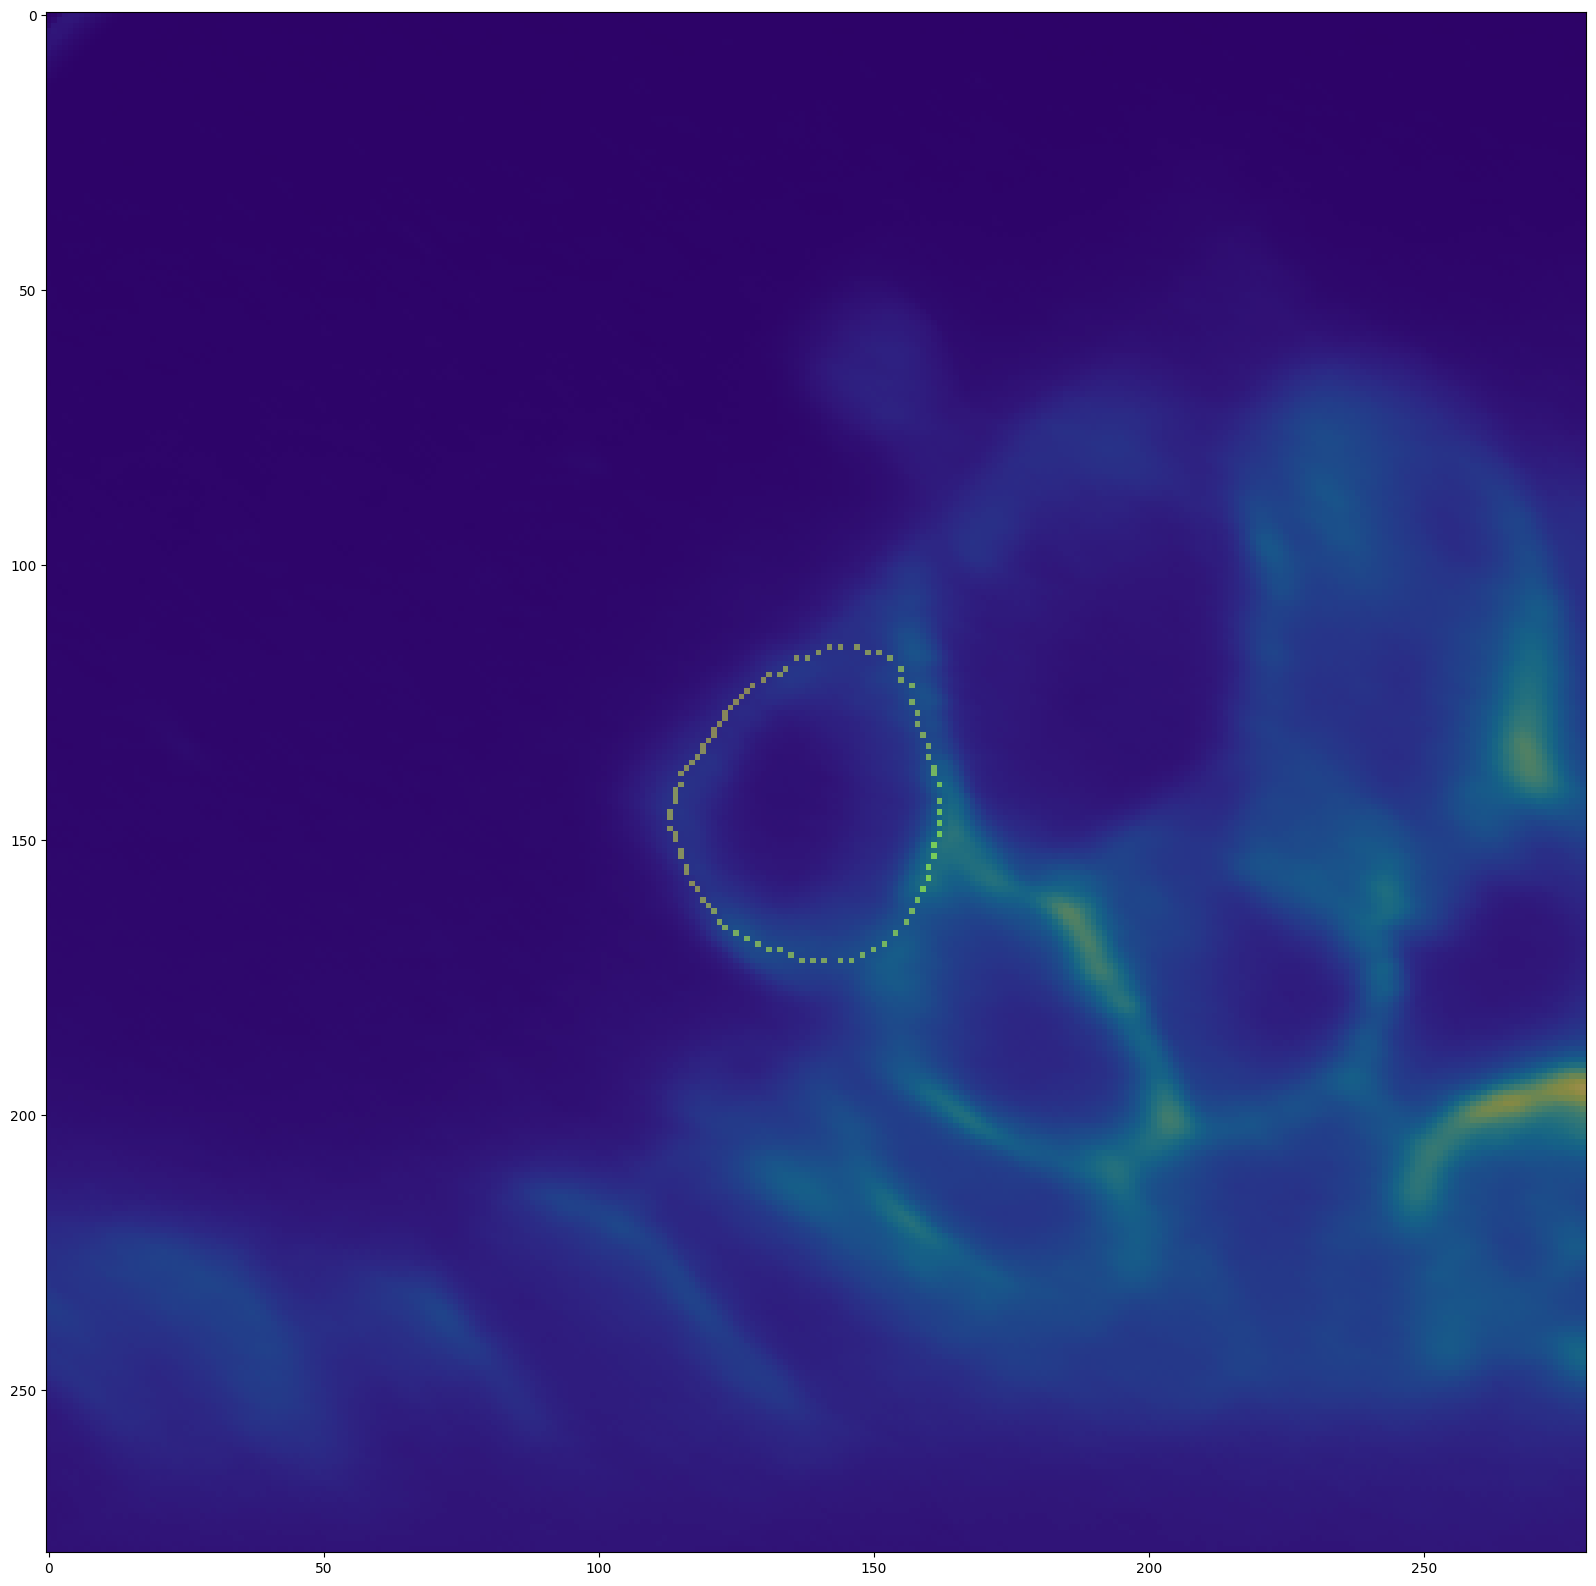

In [325]:
intensities_cartesian = np.zeros(im.shape)

def cart_y(r, a):
    y = int(r*np.cos(dAngle*a*np.pi/180)+center[0]+7)
    return y

def cart_x(r, a):
    x = int(r*np.sin(dAngle*a*np.pi/180)+center[1]-9)
    return x


for r, a in zip(middle_border, range(len(middle_border))):
    y = cart_y(r, a)
    x = cart_x(r, a)
    
    intensities_cartesian[y , x] = 1

plt.figure(figsize=(20,20))
plt.imshow(im)
plt.imshow(intensities_cartesian, alpha=0.4, cmap='plasma')




In [327]:
viewer = napari.Viewer()
viewer.add_image(im)

<Image layer 'im' at 0x1d9e92bc9d0>

(280, 280)


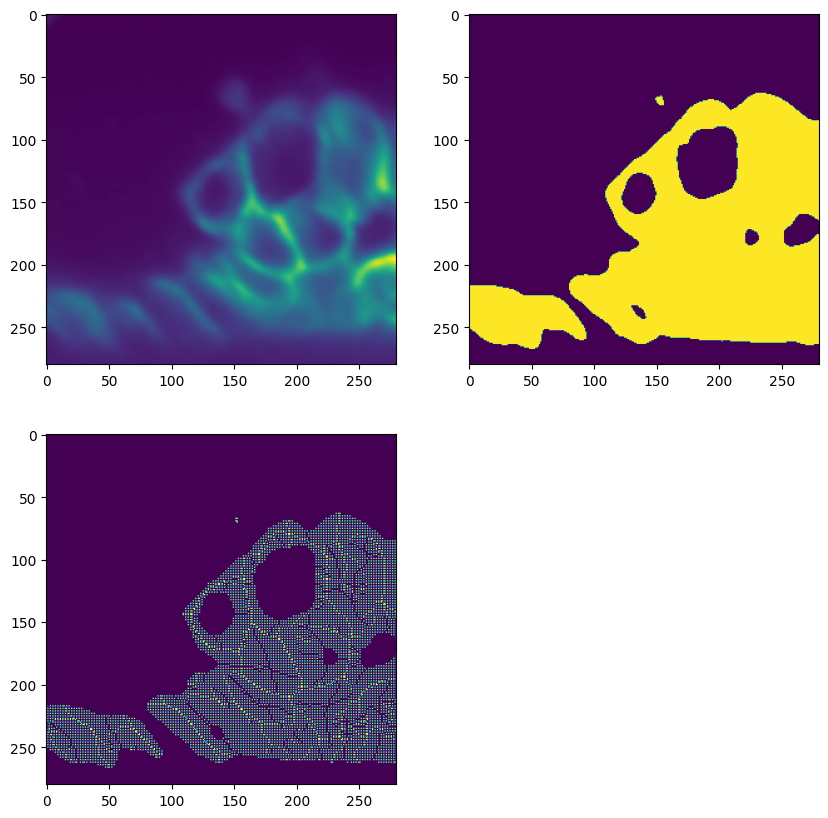

In [229]:
print(im.shape)
im22 = GaussianBlur(im, (7,7), 2)
obj = dotim(im22, is2D=True)
mask = obj.conv_deconv(times=1, binshape=(1,1))
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(im22)
plt.subplot(222)
plt.imshow(mask)
obj2 = dotim(mask*im22, is2D=True)
mask2 = obj2.conv_deconv(times=1, binshape=(2,2))
plt.subplot(223)
plt.imshow(mask2)